# SHAP for Classification — Breast Cancer
0) Setup

In [ ]:
# !pip -q install shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import shap
import warnings
warnings.filterwarnings("ignore")


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#1) Load data
# sklearn breast cancer dataset -> binary classification (malignant/benign)

In [ ]:
bc = load_breast_cancer(as_frame=True)
X = bc.data.copy()
y = bc.target.copy() # 0 = malignant, 1 = benign
feature_names = X.columns.tolist()
class_names = ["malignant", "benign"]


# Split (stratified to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

# 2) Models

In [ ]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, solver="lbfgs", random_state=RANDOM_STATE))
])


pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
])

pipe_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu",
                          alpha=1e-3, max_iter=600, random_state=RANDOM_STATE))
])


models = {
    "LogisticRegression": pipe_lr,
    "SVM(RBF)": pipe_svm,
    "MLP": pipe_mlp,
}


# Fit and quick eval
metrics = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)
    metrics[name] = {
        "ACC": accuracy_score(y_test, pred),
        "ROC_AUC": roc_auc_score(y_test, proba),
        "F1": f1_score(y_test, pred),
    }


print(pd.DataFrame(metrics).T.round(4))

                       ACC  ROC_AUC      F1
LogisticRegression  0.9883   0.9981  0.9907
SVM(RBF)            0.9825   0.9978  0.9859
MLP                 0.9708   0.9965  0.9763


# 3) SHAP Explainers

In [ ]:
shap.initjs()
background = shap.sample(X_train, 100, random_state=RANDOM_STATE)


# Helper to build explainer on model.predict_proba for class index 1 (benign)
# SHAP handles pipelines transparently by calling predict_proba on them.
explainers = {}
for name, model in models.items():
    # Use a callable that returns probabilities for class 1
    f = lambda data: model.predict_proba(pd.DataFrame(data, columns=feature_names))[:, 1]
    explainers[name] = shap.Explainer(f, background, feature_names=feature_names)

# 4) Explain 5 random test samples

Chosen test indices: [130, 74, 110, 14, 170]

=== LogisticRegression: SHAP values for 5 samples ===
Sample test idx 130 → top features:
 worst concavity                     +0.0571
 worst texture                       +0.0559
 worst concave points                +0.0408
 area error                          +0.0289
 worst radius                        +0.0263
 mean area                           +0.0252
Sample test idx 74 → top features:
 worst smoothness                    +0.0867
 area error                          +0.0391
 radius error                        +0.0309
 worst symmetry                      +0.0301
 worst radius                        +0.0227
 worst perimeter                     +0.0196
Sample test idx 110 → top features:
 mean perimeter                      -0.0957
 mean texture                        -0.0820
 smoothness error                    -0.0752
 worst smoothness                    +0.0739
 worst texture                       -0.0721
 mean radius                

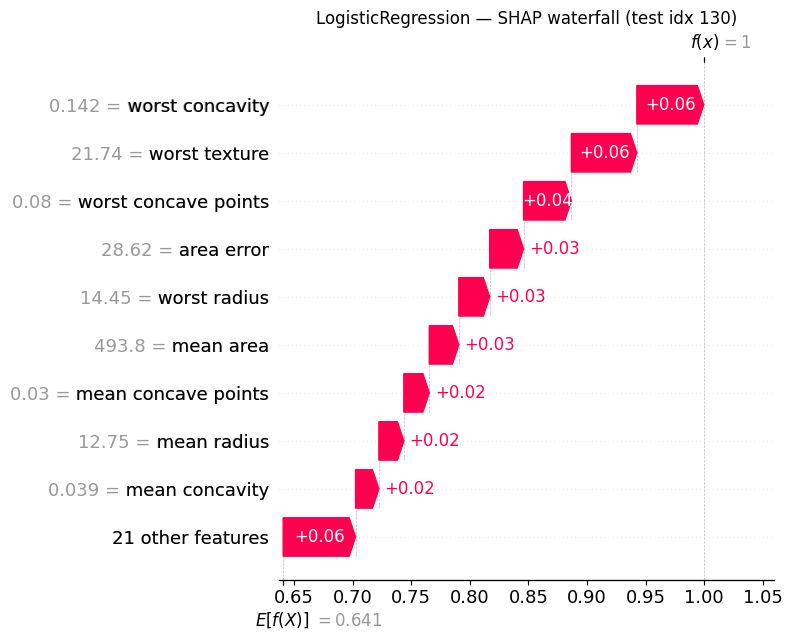

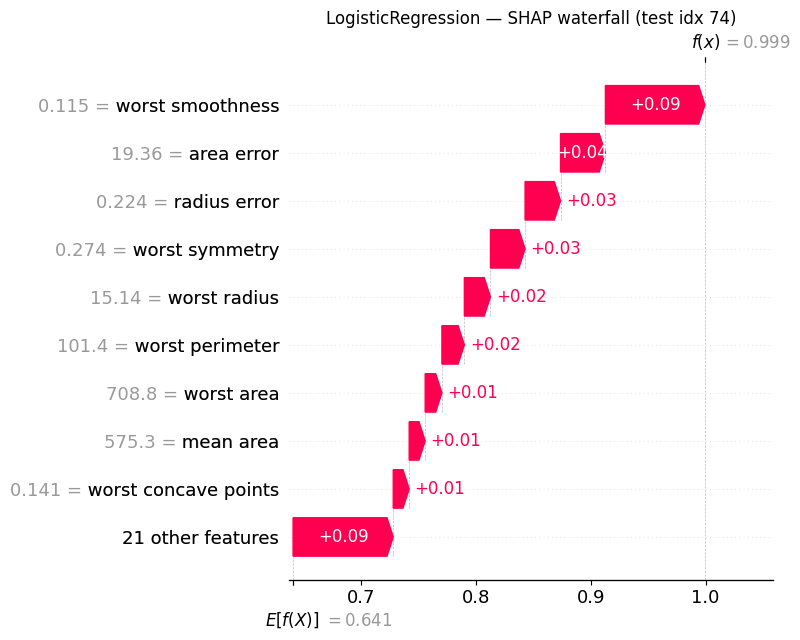

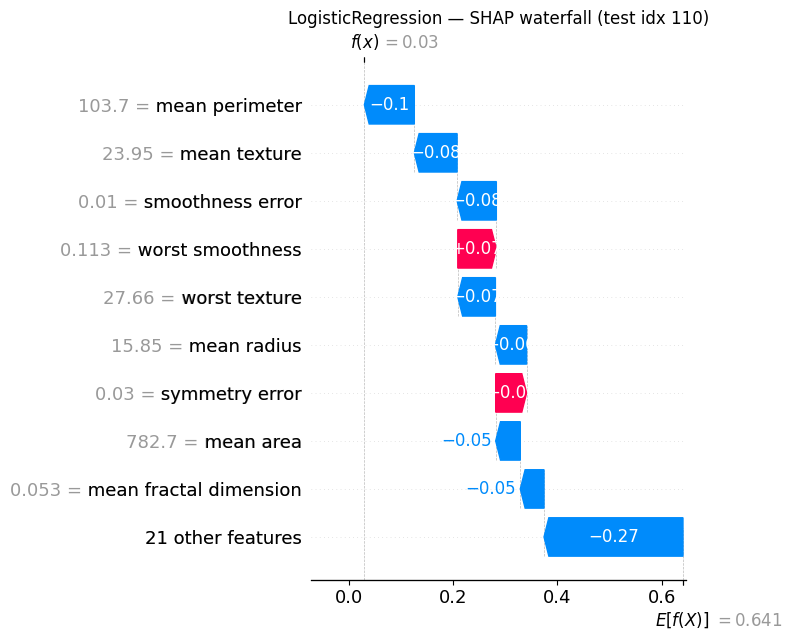

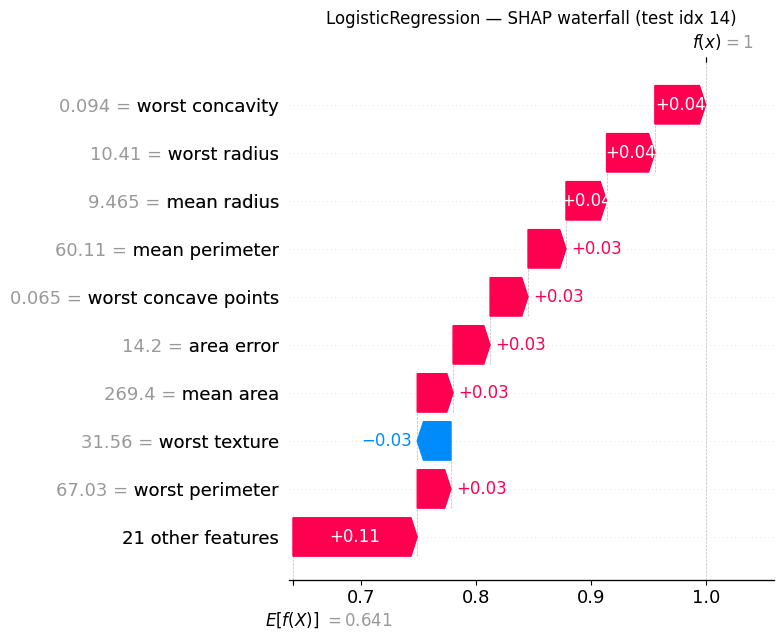

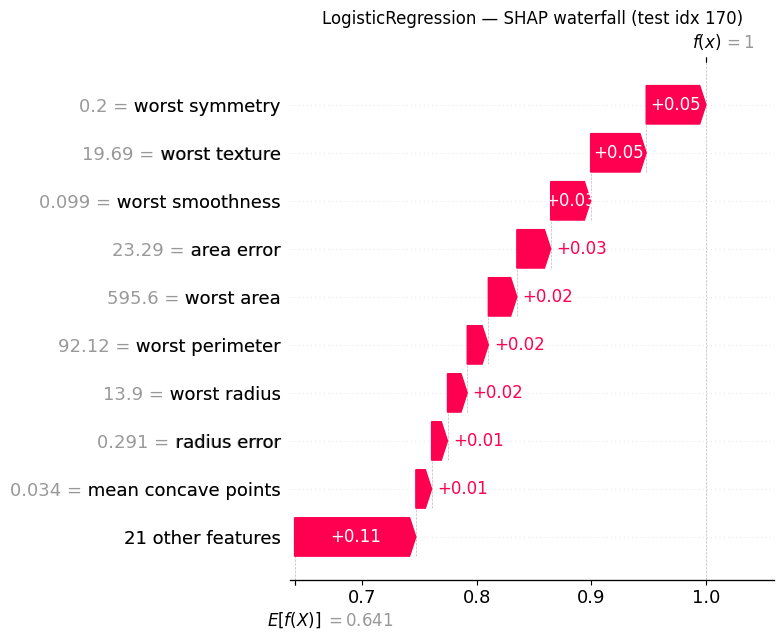


=== SVM(RBF): SHAP values for 5 samples ===
Sample test idx 130 → top features:
 worst texture                       +0.0668
 worst concavity                     +0.0468
 worst concave points                +0.0387
 area error                          +0.0304
 worst radius                        +0.0299
 mean concave points                 +0.0264
Sample test idx 74 → top features:
 worst smoothness                    +0.0966
 area error                          +0.0406
 worst symmetry                      +0.0291
 radius error                        +0.0261
 worst texture                       +0.0199
 worst perimeter                     +0.0196
Sample test idx 110 → top features:
 mean texture                        -0.0914
 worst smoothness                    +0.0796
 worst texture                       -0.0761
 mean radius                         -0.0645
 symmetry error                      +0.0633
 mean area                           -0.0504
Sample test idx 14 → top features:
 wo

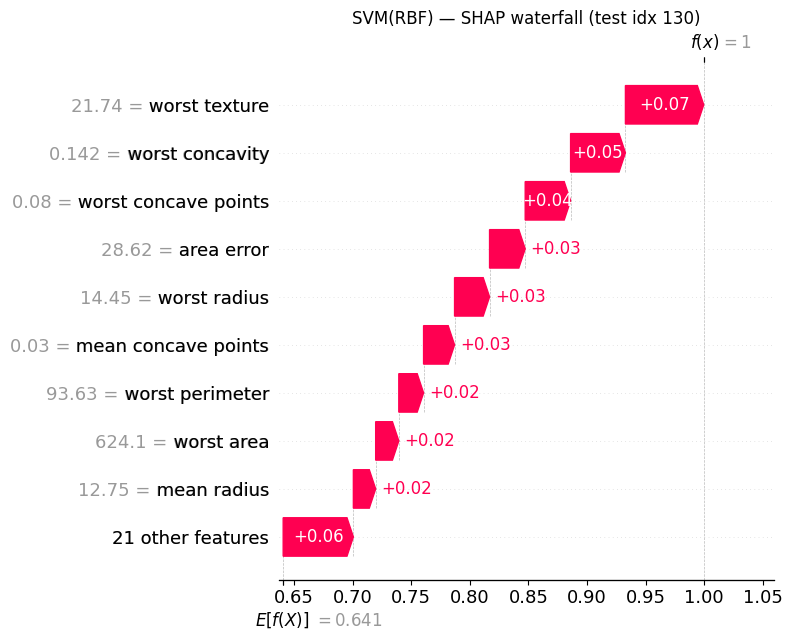

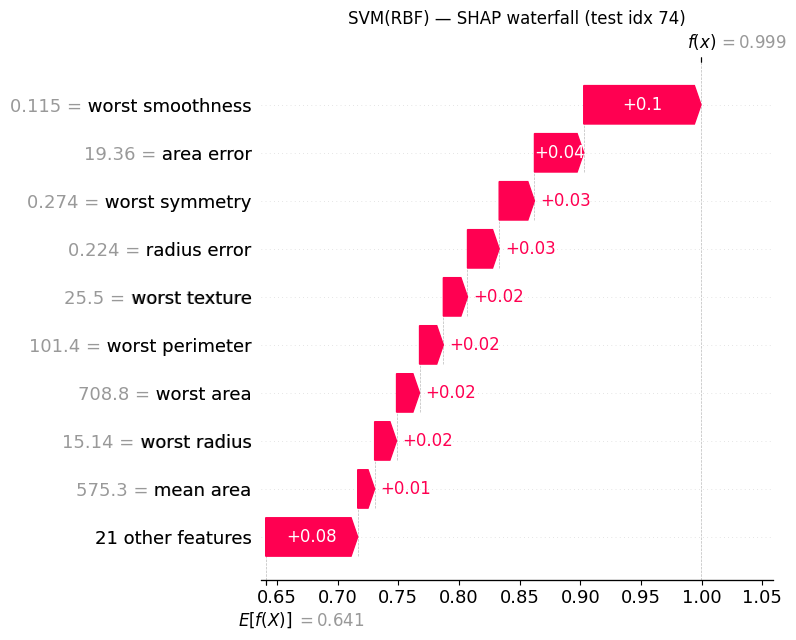

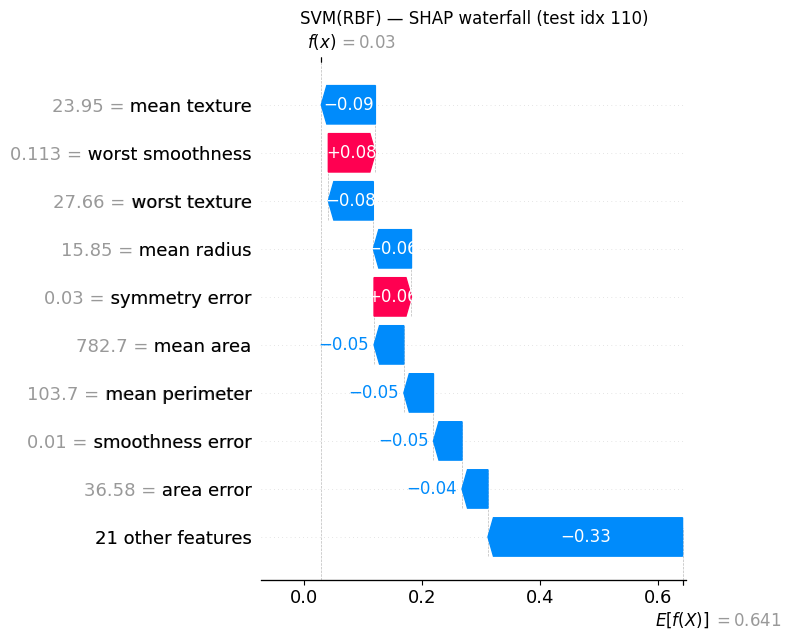

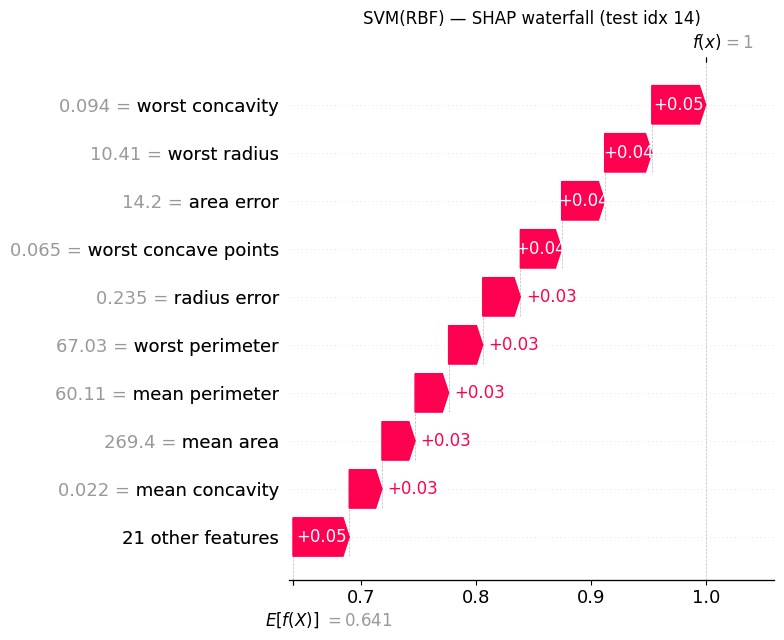

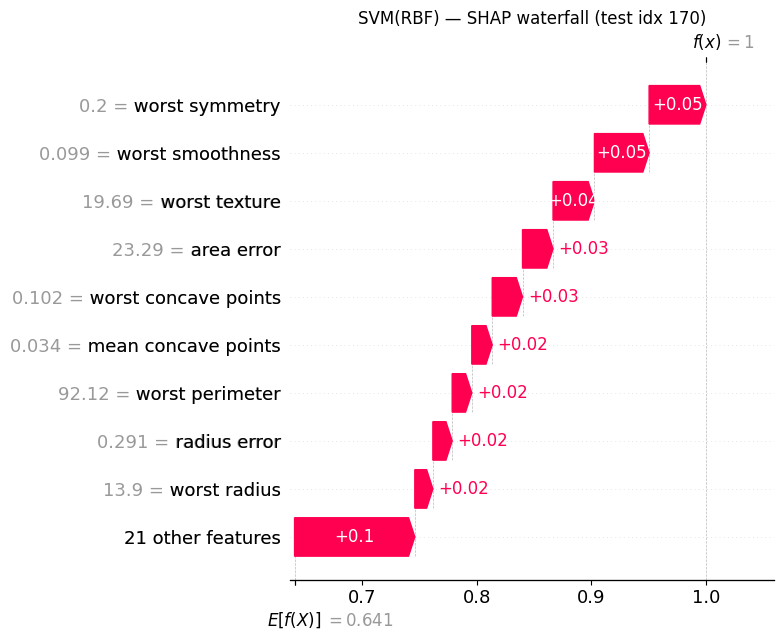


=== MLP: SHAP values for 5 samples ===
Sample test idx 130 → top features:
 worst texture                       +0.0617
 worst concavity                     +0.0490
 worst concave points                +0.0376
 area error                          +0.0374
 worst radius                        +0.0276
 mean concavity                      +0.0226
Sample test idx 74 → top features:
 worst smoothness                    +0.0792
 area error                          +0.0431
 worst symmetry                      +0.0361
 radius error                        +0.0254
 mean area                           +0.0201
 worst radius                        +0.0173
Sample test idx 110 → top features:
 mean texture                        -0.1188
 worst smoothness                    +0.1061
 worst texture                       -0.0797
 mean area                           -0.0626
 smoothness error                    -0.0617
 symmetry error                      +0.0589
Sample test idx 14 → top features:
 mean pe

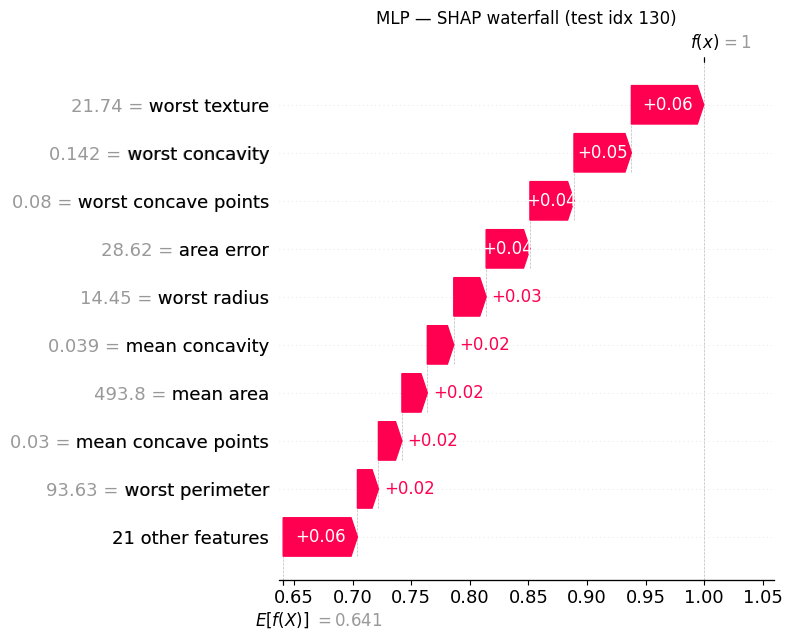

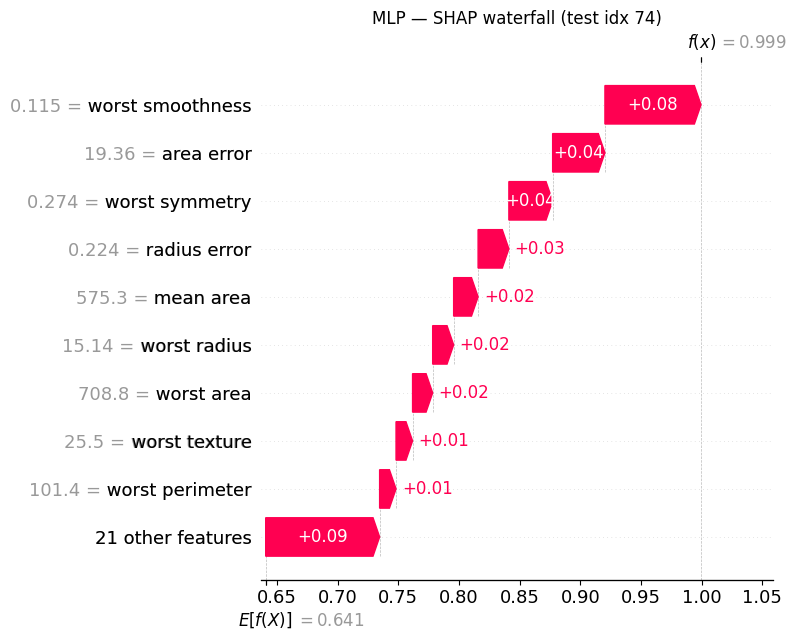

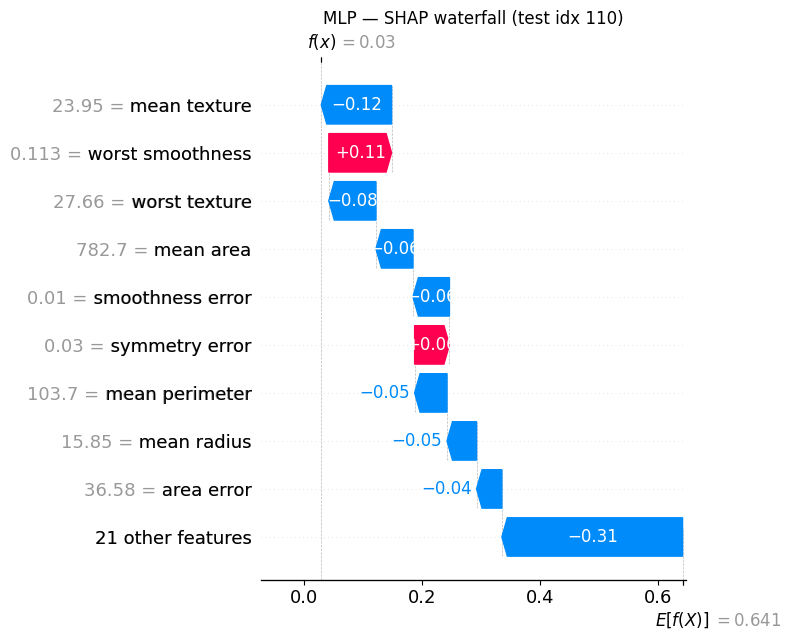

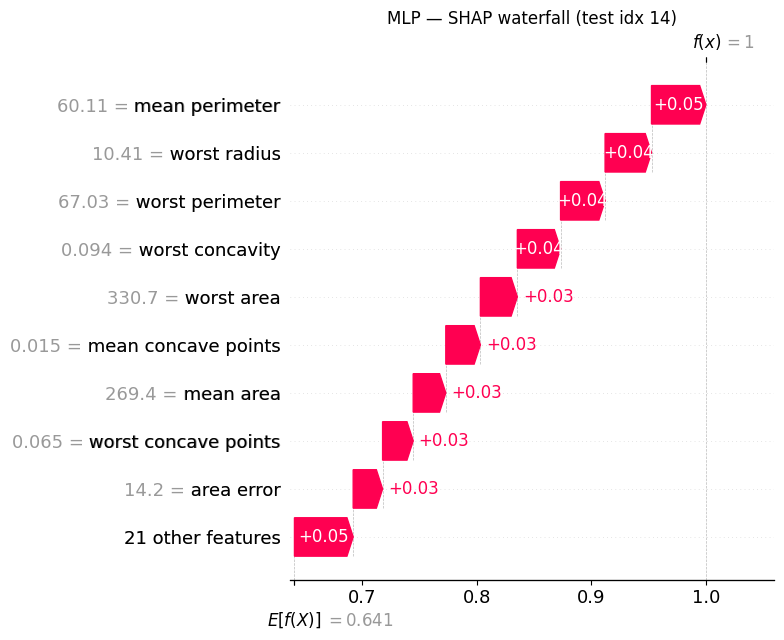

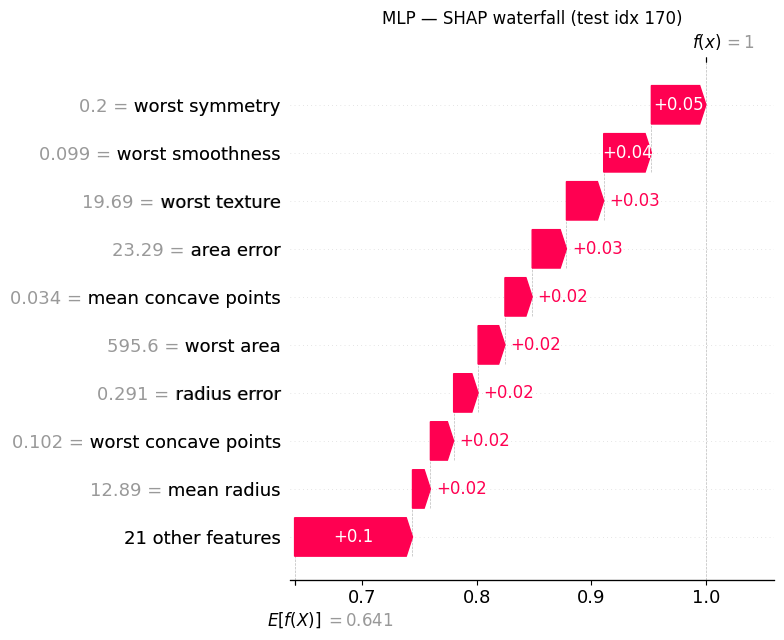

In [ ]:
rng = np.random.default_rng(RANDOM_STATE)
idx_5 = rng.choice(np.arange(len(X_test)), size=5, replace=False)
X5 = X_test.iloc[idx_5]
print("Chosen test indices:", idx_5.tolist())


per_model_explanations = {}
for name, expl in explainers.items():
    # Call explainer on the 5 instances
    exp = expl(X5)
    per_model_explanations[name] = exp
    print(f"\n=== {name}: SHAP values for 5 samples ===")
    # Show a compact dataframe of top features per instance
    # Rank by absolute SHAP value
    for i, idx in enumerate(idx_5):
        shap_vals = exp.values[i]
        order = np.argsort(-np.abs(shap_vals))[:6]
        top_feats = [(feature_names[j], float(shap_vals[j])) for j in order]
        print(f"Sample test idx {int(idx)} → top features:")
        for feat, val in top_feats:
            print(f" {feat:35s} {val:+.4f}")


    # Waterfall plots for each of the 5 samples
    for i, idx in enumerate(idx_5):
        plt.figure(figsize=(7,5))
        shap.plots.waterfall(exp[i], show=False)
        plt.title(f"{name} — SHAP waterfall (test idx {int(idx)})")
        plt.tight_layout()
        plt.show()

# 5) SHAP Summary (beeswarm) & Dependence plots (global views)

PermutationExplainer explainer: 172it [00:36,  3.46it/s]


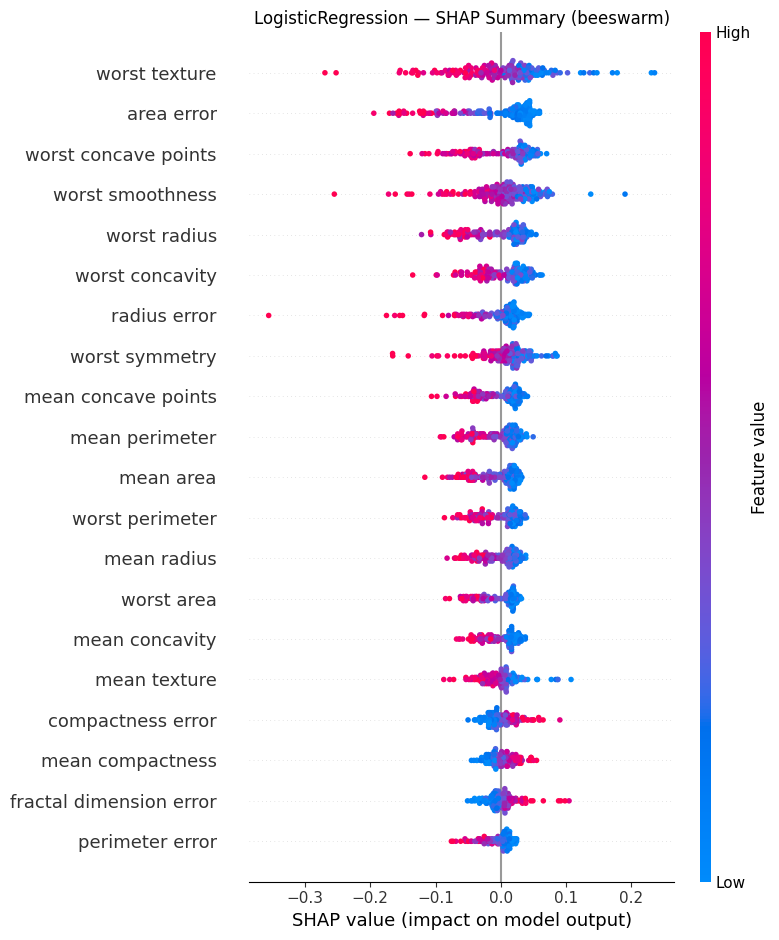

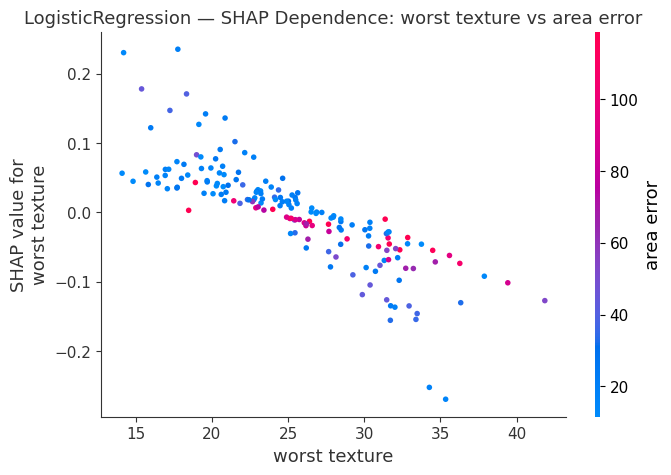

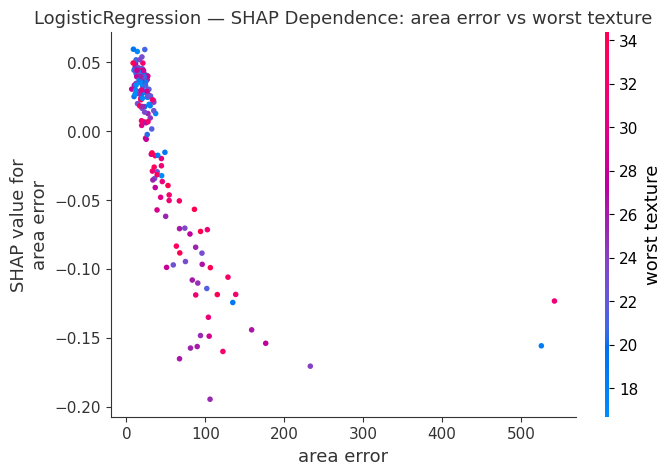

PermutationExplainer explainer: 172it [00:37,  3.37it/s]


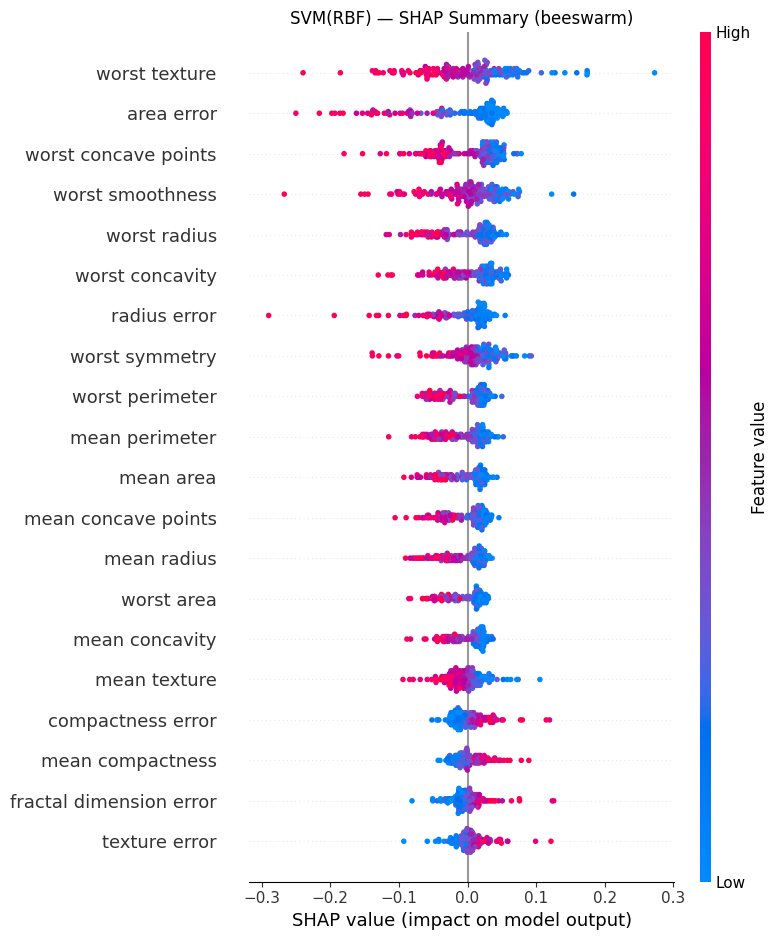

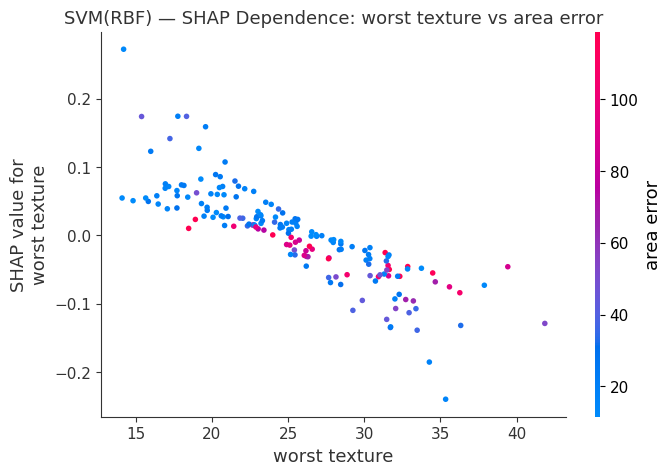

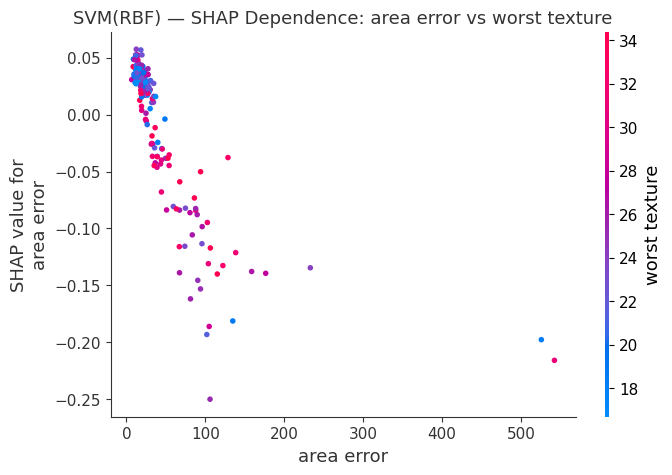

PermutationExplainer explainer: 172it [00:36,  3.22it/s]


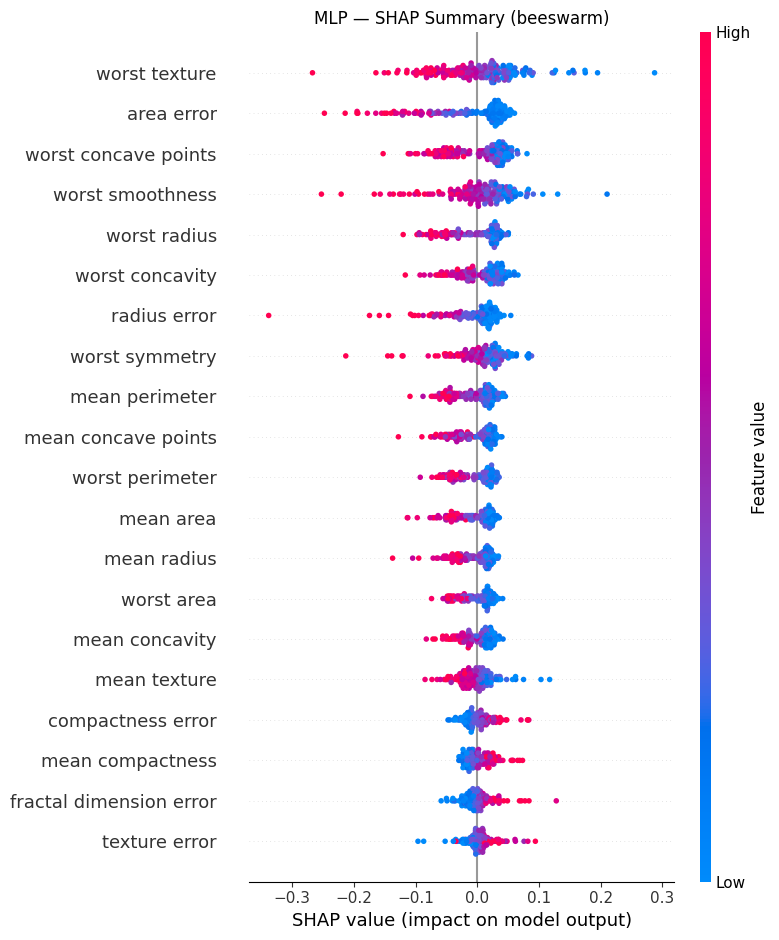

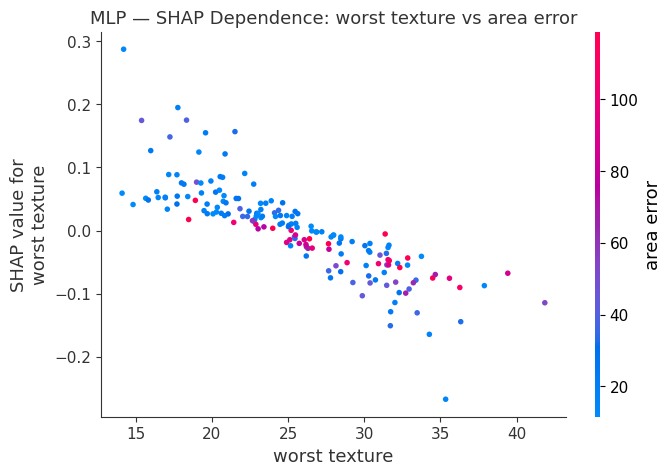

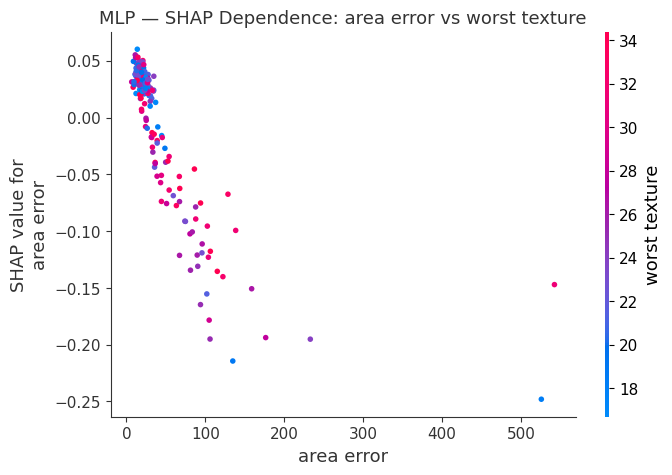

In [ ]:
X_eval = X_test.copy() # Use full test set for aggregate visualizations


for name, expl in explainers.items(): # For each model's explainer
    exp = expl(X_eval) # Compute SHAP values for all test rows


    # ---- Summary (beeswarm) plot ----
    plt.figure(figsize=(9, 6)) # Create a larger figure for readability
    shap.summary_plot(exp.values, X_eval, # Provide SHAP matrix and the corresponding features
                     feature_names=feature_names, # Ensure axis labels match columns
                     show=False) # Defer show() so we can add a title
    plt.title(f"{name} — SHAP Summary (beeswarm)") # Title describing model and plot type
    plt.tight_layout() # Improve spacing
    plt.show() # Display the beeswarm plot


    # ---- Choose top 2 features by mean |SHAP| for dependence plots ----
    mean_abs = np.mean(np.abs(exp.values), axis=0) # Compute mean absolute SHAP per feature
    top_idx = np.argsort(-mean_abs)[:2] # Indices of the two most important features


    # ---- Dependence plot for the top feature, colored by second top feature ----
    shap.dependence_plot(
        feature_names[top_idx[0]], # X-axis feature (most important)
        exp.values, # SHAP values matrix
        X_eval, # Original feature values for x-axis
        feature_names=feature_names, # Names for ticks/labels
        interaction_index=feature_names[top_idx[1]], # Color by second-most important feature
        show=True, # Render immediately
        title=f"{name} — SHAP Dependence: {feature_names[top_idx[0]]} vs {feature_names[top_idx[1]]}"
    )

    # ---- Dependence plot for the second feature, colored by the first ----
    shap.dependence_plot(
        feature_names[top_idx[1]], # X-axis feature (second-most important)
        exp.values,
        X_eval,
        feature_names=feature_names,
        interaction_index=feature_names[top_idx[0]], # Color by the most important feature
        show=True,
        title=f"{name} — SHAP Dependence: {feature_names[top_idx[1]]} vs {feature_names[top_idx[0]]}"
    )
